# Test Notebook

In [1]:
from comet_ml import Experiment

import sys, os

#Our project root directory
PROJECT_ROOT = os.path.abspath(os.path.join(os.path.dirname("__file__"), os.pardir))
sys.path.append(PROJECT_ROOT)

#Local packages loaded from src specifying useful constants, and our custom loader
from util.constants import DATA_PATHS
from util.dataset import OcelotDatasetLoader, OcelotDatasetLoader2, PixelThreshold
from util.unet import Unet
from util.evaluate import evaluate
import argparse

#other modules of interest
import torch
from torch.utils.data import DataLoader
import torchmetrics
from torchvision import transforms as transf
from PIL import Image
import numpy as np
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt
from monai.losses import DiceCELoss, DiceLoss, MaskedDiceLoss
import copy
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
my_device = torch.device(device = 'cuda' if torch.cuda.is_available() else 'cpu')
pin_memory = True if my_device == 'cuda' else False
d_type_f32 = torch.float32
batch_size = 1
learning_rate= 1e-3
weight_decay = 1e-3
nepochs = 10
val_percent=0.1
train_percent = 1 - val_percent
image_transforms = transf.Compose([transf.Resize((128,128)), transf.ToTensor()])
mask_transforms = transf.Compose([transf.Resize((128,128)), transf.ToTensor(), PixelThreshold(lower_thresh=1, upper_thresh=255)])

#First we need to specify some info on our model: we have 3 channels RGB, 1 class: tissue
model = Unet(n_channels=3, n_classes=1)

In [ ]:
train_transform =   A.Compose([ A.Resize(128,128),
                                A.HorizontalFlip(p=0.5), #TODO: FIX FOR SCORING
                                ToTensorV2()])
valtest_transform = A.Compose([ A.Resize(128,128),
                                ToTensorV2()])           #TODO: FIX FOR SCORING

In [ ]:
datasetroot = "/uufs/chpc.utah.edu/common/home/u6052852/ocelot/data/ocelot2023_v0.1.2"
scratchDirData = '/scratch/general/nfs1/u6052852/REU/Data0'

train = list(pd.read_csv(os.path.join(scratchDirData,'train.csv'), header=None).loc[:,0])
val   = list(pd.read_csv(os.path.join(scratchDirData,'val.csv'),   header=None).loc[:,0])
test  = list(pd.read_csv(os.path.join(scratchDirData,'test.csv'),  header=None).loc[:,0])

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.]]])
tensor([0., 1.])
tensor(1.)


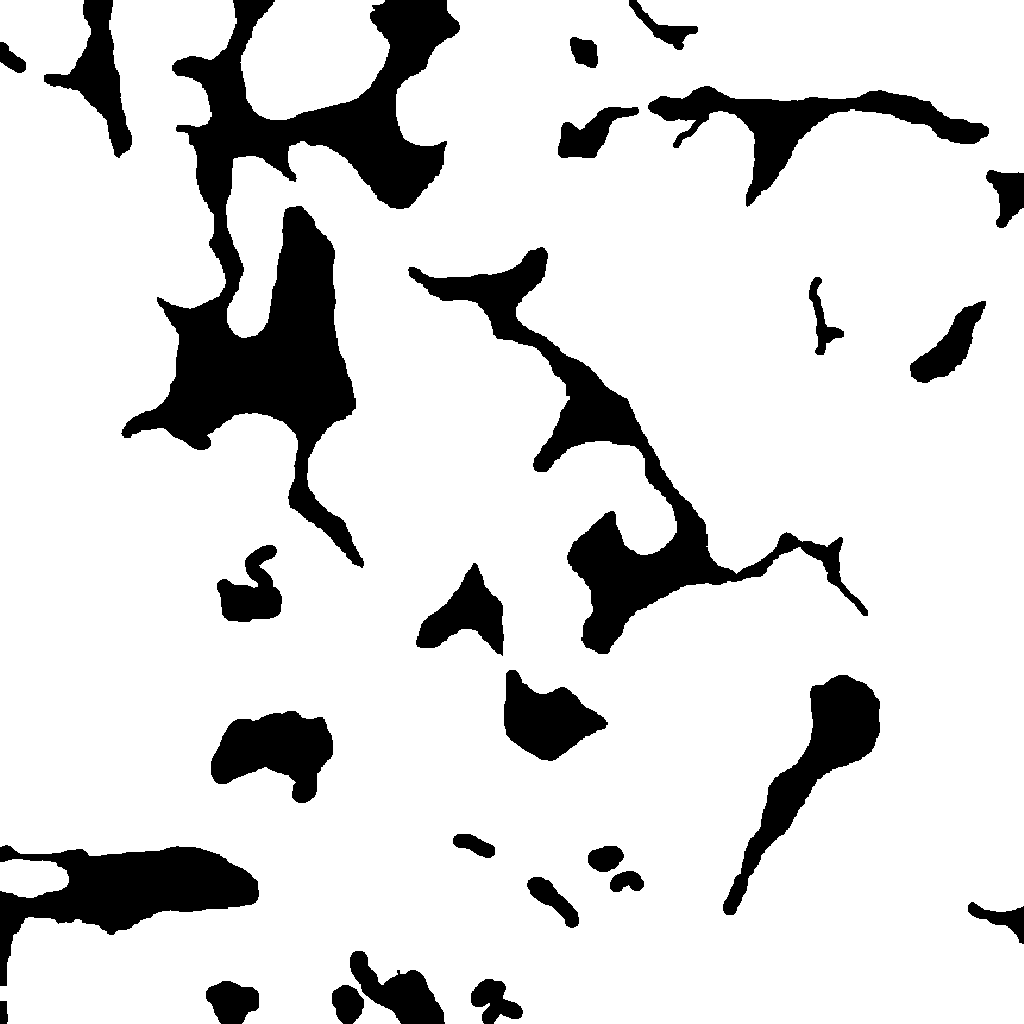

In [3]:
train_split = OcelotDatasetLoader2(train,
                                    datasetroot,
                                    transforms=train_transform) 
val_split   = OcelotDatasetLoader2(val,
                                    datasetroot,
                                    transforms=valtest_transform) 
testData  = OcelotDatasetLoader2(test,
                                    datasetroot,
                                    transforms=valtest_transform) 

#We pass into dataloader provided by torch
train_loader = DataLoader(train_split, 
                            batch_size=args.batchSize, 
                        num_workers=4)
val_loader = DataLoader(val_split, 
                        batch_size=args.batchSize, 
                        num_workers=4)
test_loader = DataLoader(testData,
                            batch_size=args.batchSize,
                            pin_memory=4)
